In [1]:
import os
import re
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# EDA

In [2]:
df_ = pd.read_csv("/content/drive/MyDrive/KLTN/coursera_courses.csv")
df_.drop("course_url", axis=1,inplace=True)
df= df_.copy()
df.head()

,course_title,course_organization,course_certificate_type,course_time,course_rating,course_reviews_num,course_difficulty,course_students_enrolled,course_skills,course_summary,course_description
0,(ISC)² Systems Security Certified Practitioner...,ISC2,Specialization,3 - 6 Months,4.7,492,Beginner,"6,958","['Risk Management', 'Access Control', 'Asset',...",[],Pursue better IT security job opportunities an...
1,.NET FullStack Developer,Board Infinity,Specialization,1 - 3 Months,4.3,51,Intermediate,"2,531","['Web API', 'Web Development', 'Cascading Styl...",['Master .NET full stack web dev: from .NET co...,Develop the proficiency required to design and...
2,21st Century Energy Transition: how do we make...,University of Alberta,Course,1 - 3 Months,4.8,62,Beginner,"4,377",[],['Understand the complexity of systems supplyi...,"Affordable, abundant and reliable energy is fu..."
3,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,Course,1 - 3 Months,4.7,517,Intermediate,"39,004","['Instrumental Variable', 'Propensity Score Ma...",[],We have all heard the phrase “correlation does...
4,A life with ADHD,University of Geneva,Course,1 - 3 Months,NaN,NaN,Beginner,NaN,"['differential diagnosis and comorbidities', '...",[' Understand what ADHD is and the challenges ...,What is ADHD and what are the challenges that ...


In [3]:
df.shape

(1000, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   course_title              1000 non-null   object 
 1   course_organization       1000 non-null   object 
 2   course_certificate_type   1000 non-null   object 
 3   course_time               1000 non-null   object 
 4   course_rating             994 non-null    float64
 5   course_reviews_num        994 non-null    object 
 6   course_difficulty         1000 non-null   object 
 7   course_students_enrolled  959 non-null    object 
 8   course_skills             1000 non-null   object 
 9   course_summary            1000 non-null   object 
 10  course_description        999 non-null    object 
dtypes: float64(1), object(10)
memory usage: 86.1+ KB


In [5]:
df.describe()

,course_rating
count,994.000000
mean,4.678370
std,0.193565
min,2.700000
25%,4.600000
50%,4.700000
75%,4.800000
max,5.000000


In [6]:
df.isnull().sum()

course_title                 0
course_organization          0
course_certificate_type      0
course_time                  0
course_rating                6
course_reviews_num           6
course_difficulty            0
course_students_enrolled    41
course_skills                0
course_summary               0
course_description           1
dtype: int64

<Axes: >

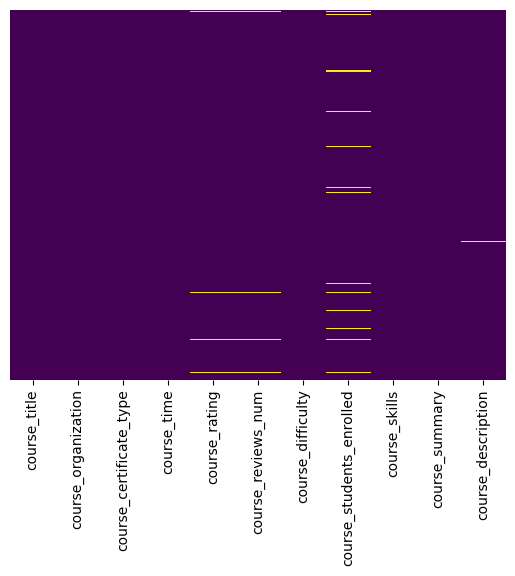

In [7]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

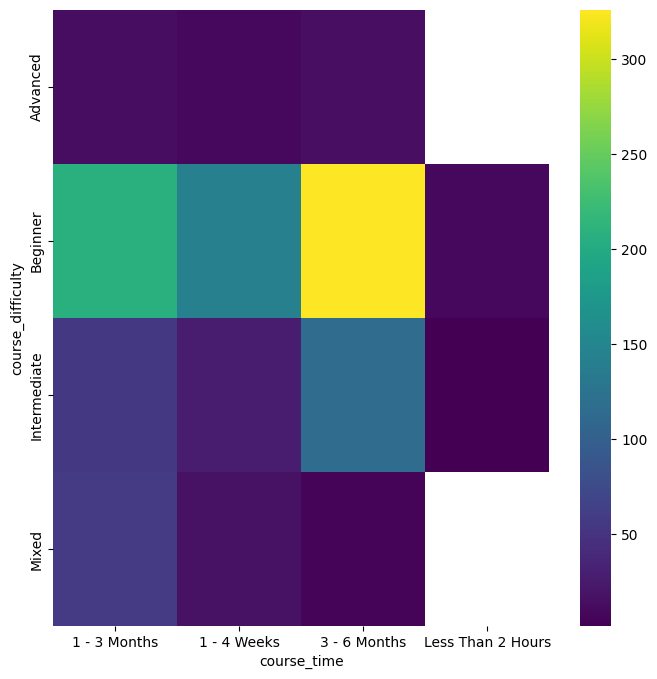

In [8]:
# @title course_time vs course_difficulty

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['course_difficulty'].value_counts()
    for x_label, grp in df.groupby('course_time')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('course_time')
_ = plt.ylabel('course_difficulty')

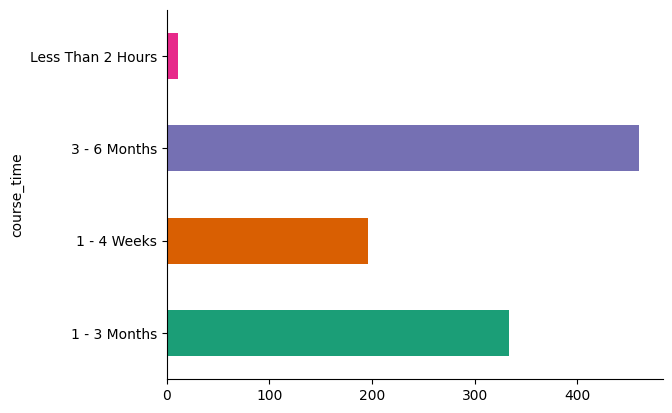

In [9]:
# @title course_time

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('course_time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

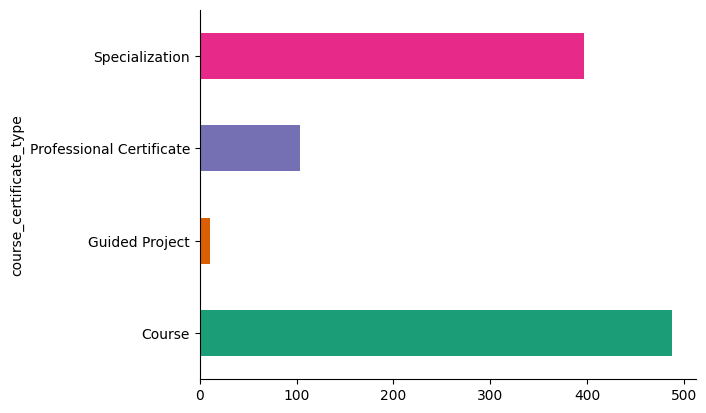

In [10]:
# @title course_certificate_type

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('course_certificate_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

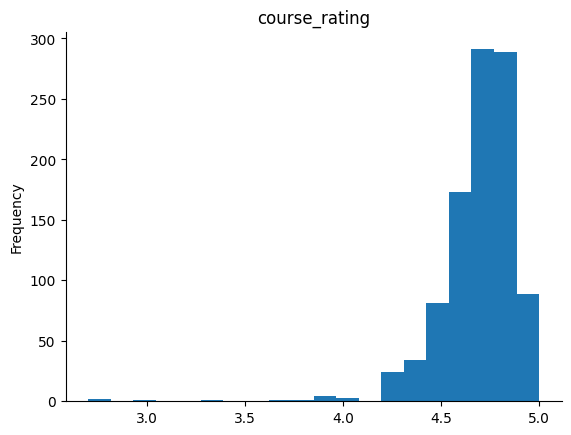

In [11]:
# @title course_rating

from matplotlib import pyplot as plt
df['course_rating'].plot(kind='hist', bins=20, title='course_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Content-based

Preprocessing

In [12]:
mean_students_enrolled = df["course_students_enrolled"].str.replace(",", "").astype(float).mean()
df["course_students_enrolled"].fillna(mean_students_enrolled, inplace=True)

df.dropna(subset=['course_description'], inplace=True)

In [13]:
df["course_students_enrolled"].isnull().any()

False

In [14]:
import re

pattern = r'ab*'
text = 'ababbba'
matches = re.findall(pattern, text)
print(matches)

['ab', 'abbb', 'a']


In [15]:
df['course_description'].head()

0    Pursue better IT security job opportunities an...
1    Develop the proficiency required to design and...
2    Affordable, abundant and reliable energy is fu...
3    We have all heard the phrase “correlation does...
4    What is ADHD and what are the challenges that ...
Name: course_description, dtype: object

In [16]:
df['course_description'] = df['course_description'].apply(lambda x: re.sub(r'[-.:,“]', ' ', x))
df['course_description'].head()

0    Pursue better IT security job opportunities an...
1    Develop the proficiency required to design and...
2    Affordable  abundant and reliable energy is fu...
3    We have all heard the phrase  correlation does...
4    What is ADHD and what are the challenges that ...
Name: course_description, dtype: object

In [17]:
print(df["course_description"].isnull().any())
df['course_description'] = df['course_description'].fillna('')
tfidf = TfidfVectorizer(stop_words='english')

False


In [18]:
tfidf_matrix = tfidf.fit_transform(df['course_description'])

In [19]:
tfidf.get_feature_names_out

<bound method CountVectorizer.get_feature_names_out of TfidfVectorizer(stop_words='english')>

In [20]:
tfidf_matrix.toarray()

array([[0.06213267, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [21]:
similarity = cosine_similarity(tfidf_matrix,tfidf_matrix)

In [22]:
similarity

array([[1.00000000e+00, 1.41317610e-02, 1.88098194e-02, ...,
        1.18091568e-03, 0.00000000e+00, 0.00000000e+00],
       [1.41317610e-02, 1.00000000e+00, 2.25333328e-03, ...,
        3.88138742e-04, 0.00000000e+00, 0.00000000e+00],
       [1.88098194e-02, 2.25333328e-03, 1.00000000e+00, ...,
        2.55301963e-04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.18091568e-03, 3.88138742e-04, 2.55301963e-04, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 2.07537539e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.07537539e-02, 1.00000000e+00]])

In [23]:
indices = pd.Series(df.index, index=df['course_title']).drop_duplicates()

In [24]:
indices[0:10]

course_title
(ISC)² Systems Security Certified Practitioner (SSCP)                             0
.NET FullStack Developer                                                          1
21st Century Energy Transition: how do we make it work?                           2
A Crash Course in Causality:  Inferring Causal Effects from Observational Data    3
A life with ADHD                                                                  4
AI & Law                                                                          5
AI Applications in Marketing and Finance                                          6
AI Applications in People Management                                              7
AI For Business                                                                   8
AI For Everyone                                                                   9
dtype: int64

In [25]:
indices.index.value_counts()

course_title
Machine Learning                                                         2
Google UX Design                                                         2
Business Analytics                                                       2
Introduction to Psychology                                               2
Introduction to Project Management                                       2
                                                                        ..
Financial Management                                                     1
Financial Markets                                                        1
Financial Planning for Young Adults                                      1
Financial Reporting                                                      1
用 Python 做商管程式設計（二）(Programming for Business Computing in Python (2))    1
Name: count, Length: 992, dtype: int64

In [26]:
# If multiple courses have the same title,\
# it keeps only the last one. This ensures that each course has a unique index.
indices = indices[~indices.index.duplicated(keep='last')]

In [27]:
# Finds the index of the course with the title 'Data Science'.
course_index = indices["Data Science"]

# Retrieves an array containing the similarities of the 'Data Science' course with other courses.
similarity[course_index]

array([1.45719627e-02, 1.76195056e-02, 0.00000000e+00, 2.28985351e-01,
       2.83096754e-03, 9.18772513e-03, 1.03398001e-02, 2.38446868e-02,
       6.20171593e-02, 1.63237866e-02, 2.05859693e-03, 2.90928705e-02,
       2.28794727e-02, 3.52664589e-02, 7.24629073e-02, 4.10475818e-03,
       5.93971732e-03, 2.22571417e-02, 2.76515031e-02, 4.65142637e-02,
       2.76490147e-02, 3.42690739e-02, 8.96241749e-03, 0.00000000e+00,
       3.20926808e-03, 1.18000453e-02, 7.38473238e-03, 2.41835256e-02,
       1.43170728e-02, 1.89329180e-02, 5.47255451e-02, 2.86375266e-02,
       1.13671010e-02, 5.77724483e-02, 7.02193616e-03, 1.75421230e-01,
       4.56794328e-02, 2.09977909e-02, 5.74546321e-02, 3.33476345e-02,
       4.00022596e-02, 2.67217587e-02, 3.59468943e-02, 1.91498528e-02,
       8.55360059e-03, 2.60280856e-02, 2.17690124e-02, 9.36532242e-03,
       7.41658560e-02, 4.09816034e-02, 1.23531927e-02, 0.00000000e+00,
       1.46599528e-02, 0.00000000e+00, 0.00000000e+00, 3.80105930e-02,
      

In [28]:
# Creates a DataFrame containing the similarity scores.
similarity_scores = pd.DataFrame(similarity[course_index], columns=["score"])

In [29]:
course_indices = similarity_scores.sort_values("score", ascending=False)[1:11].index

In [30]:
df['course_title'].iloc[course_indices]

707            Methods and Statistics in Social Sciences
3      A Crash Course in Causality:  Inferring Causal...
218                         Data Engineering Foundations
817                               Psychological Research
899                               Statistics with Python
126      Business Sustainability in the Circular Economy
385               Fundamentals of Reinforcement Learning
104                                Blockchain Revolution
35                           Advanced Business Analytics
776                                   Pre-MBA Statistics
Name: course_title, dtype: object

In [31]:
# Final Function
def get_recommendations_course(title, cosine_sim=similarity):
    indices = pd.Series(df.index, index=df['course_title']).drop_duplicates()
    indices = indices[~indices.index.duplicated(keep='last')]
    course_index = indices[title]
    cosine_sim[course_index]
    similarity_scores = pd.DataFrame(cosine_sim[course_index],
                                 columns=["score"])
    course_indices = similarity_scores.sort_values("score", ascending=False)[1:11].index
    return df['course_title'].iloc[course_indices]

In [32]:
get_recommendations_course('AI & Law')

53                       An Introduction to American Law
569         Introduction to Environmental Law and Policy
184                                      Cost Accounting
160           Coding for Beginners: An Easy Introduction
464                   Healthcare Organization Operations
51                               American Contract Law I
306        Everyday Parenting: The ABCs of Child Rearing
570                Introduction to Environmental Science
728                         Music Education for Teachers
533    International Law In Action: Investigating and...
Name: course_title, dtype: object

In [33]:
get_recommendations_course('Psychological Research')

357                          Foundations of Data Science
768       Politics and Economics of International Energy
427                                Google Data Analytics
212    Data Analysis and Presentation Skills: the PwC...
84                   Astronomy: Exploring Time and Space
557                       Introduction to Data Analytics
91     BI Foundations with SQL, ETL and Data Warehousing
951                    Tools of the Trade: Linux and SQL
166                           Computational Neuroscience
213          Data Analysis and Visualization Foundations
Name: course_title, dtype: object

# Demorgraphic Filtering

In [34]:
df

,course_title,course_organization,course_certificate_type,course_time,course_rating,course_reviews_num,course_difficulty,course_students_enrolled,course_skills,course_summary,course_description
0,(ISC)² Systems Security Certified Practitioner...,ISC2,Specialization,3 - 6 Months,4.7,492,Beginner,"6,958","['Risk Management', 'Access Control', 'Asset',...",[],Pursue better IT security job opportunities an...
1,.NET FullStack Developer,Board Infinity,Specialization,1 - 3 Months,4.3,51,Intermediate,"2,531","['Web API', 'Web Development', 'Cascading Styl...",['Master .NET full stack web dev: from .NET co...,Develop the proficiency required to design and...
2,21st Century Energy Transition: how do we make...,University of Alberta,Course,1 - 3 Months,4.8,62,Beginner,"4,377",[],['Understand the complexity of systems supplyi...,Affordable abundant and reliable energy is fu...
3,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,Course,1 - 3 Months,4.7,517,Intermediate,"39,004","['Instrumental Variable', 'Propensity Score Ma...",[],We have all heard the phrase correlation does...
4,A life with ADHD,University of Geneva,Course,1 - 3 Months,NaN,NaN,Beginner,143610.014599,"['differential diagnosis and comorbidities', '...",[' Understand what ADHD is and the challenges ...,What is ADHD and what are the challenges that ...
...,...,...,...,...,...,...,...,...,...,...,...
995,Étudier en France: French Intermediate course ...,École Polytechnique,Course,1 - 3 Months,4.8,4.6k,Intermediate,"519,333",[],[],Ce cours de français de niveau intermédiaire B...
996,Цифровий маркетинг і електронна комерція від G...,Google,Professional Certificate,3 - 6 Months,4.9,1.2k,Beginner,"7,630","['Медійна реклама', 'Маркетинг', 'Маркетинг ел...",['Ви вивчите основи цифрового маркетингу та ел...,За менш ніж шість місяців без досвіду або спе...
997,تحليلات البيانات من Google,Google,Professional Certificate,3 - 6 Months,4.8,156,Beginner,"2,701","['مؤثرات عرض البيانات (DataViz)', 'R Markdown'...",['اكتساب فهم شامل للممارسات والعمليات التي يست...,استعد لمهنة جديدة في مجال تحليلات البيانات عال...
998,用 Python 做商管程式設計（一）(Programming for Business C...,National Taiwan University,Course,1 - 3 Months,4.9,814,Beginner,"38,595",[],[],本系列課程從零開始，教授一般認為最適合初學者的程式語言「Python」，目標是讓大家在完成本...


In [35]:
df['course_reviews_num']

0       492
1        51
2        62
3       517
4       NaN
       ... 
995    4.6k
996    1.2k
997     156
998     814
999     249
Name: course_reviews_num, Length: 999, dtype: object

In [36]:
int(float(df['course_reviews_num'][995][:-1]) * 1000)

4600

In [37]:
for i in range(0,df.shape[0]):
    if pd.isnull(df['course_reviews_num'].iloc[i]):
      df['course_reviews_num'].iloc[i] = 0
    if isinstance(df['course_reviews_num'].iloc[i], str) and 'k' in df['course_reviews_num'].iloc[i]:
      df['course_reviews_num'].iloc[i] = int(float(df['course_reviews_num'].iloc[i][:-1]) * 1000)
    else:
      df['course_reviews_num'].iloc[i] = int(df['course_reviews_num'].iloc[i])


Streaming output truncated to the last 5000 lines.
<ipython-input-37-7d5cd6f1d1e2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['course_reviews_num'].iloc[i] = int(df['course_reviews_num'].iloc[i])
<ipython-input-37-7d5cd6f1d1e2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['course_reviews_num'].iloc[i] = int(df['course_reviews_num'].iloc[i])
<ipython-input-37-7d5cd6f1d1e2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [38]:
df['course_reviews_num']

0       492
1        51
2        62
3       517
4         0
       ... 
995    4600
996    1200
997     156
998     814
999     249
Name: course_reviews_num, Length: 999, dtype: object

In [39]:
c = df['course_rating'].mean()
m = df['course_reviews_num'].quantile(0.95)
qualified_courses = df.copy().loc[df['course_reviews_num']>=m]
qualified_courses.shape

(51, 11)

In [40]:
def weighted_rating(x):
  v = x['course_reviews_num']
  r = x['course_rating']
  return (v/(v+m)*r) + (m/(v+m)*c)

In [41]:
qualified_courses['score'] = qualified_courses.apply(weighted_rating,axis=1)
qualified_courses.shape

(51, 12)

In [42]:
#Sort movies based on score calculated above
qualified_courses = qualified_courses.sort_values('score', ascending=False)

#Print the top 10 movies
qualified_courses[['course_title','course_reviews_num','course_rating','score']].head(10)

,course_title,course_reviews_num,course_rating,score
742,Neuroscience and Neuroimaging,119900,4.9,4.842728
139,Calculus for Machine Learning and Data Science,94900,4.9,4.832254
822,Python Data Structures,93900,4.9,4.831755
363,Foundations of Public Health Practice,73000,4.9,4.819331
508,Improving Deep Neural Networks: Hyperparameter...,62500,4.9,4.811210
314,Excel for Beginners: Introduction to Spreadsheets,58900,4.9,4.808035
347,Fondamentaux de la cybersécurité,48500,4.9,4.797444
315,Excel for Beginners: Pivot Tables,47500,4.9,4.796295
181,Corporate & Commercial Law I: Contracts & Empl...,41800,4.9,4.789225
830,Python for Everybody,268200,4.8,4.783610
